In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
%matplotlib inline

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv("../data/South African Heart Disease.txt")
names = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


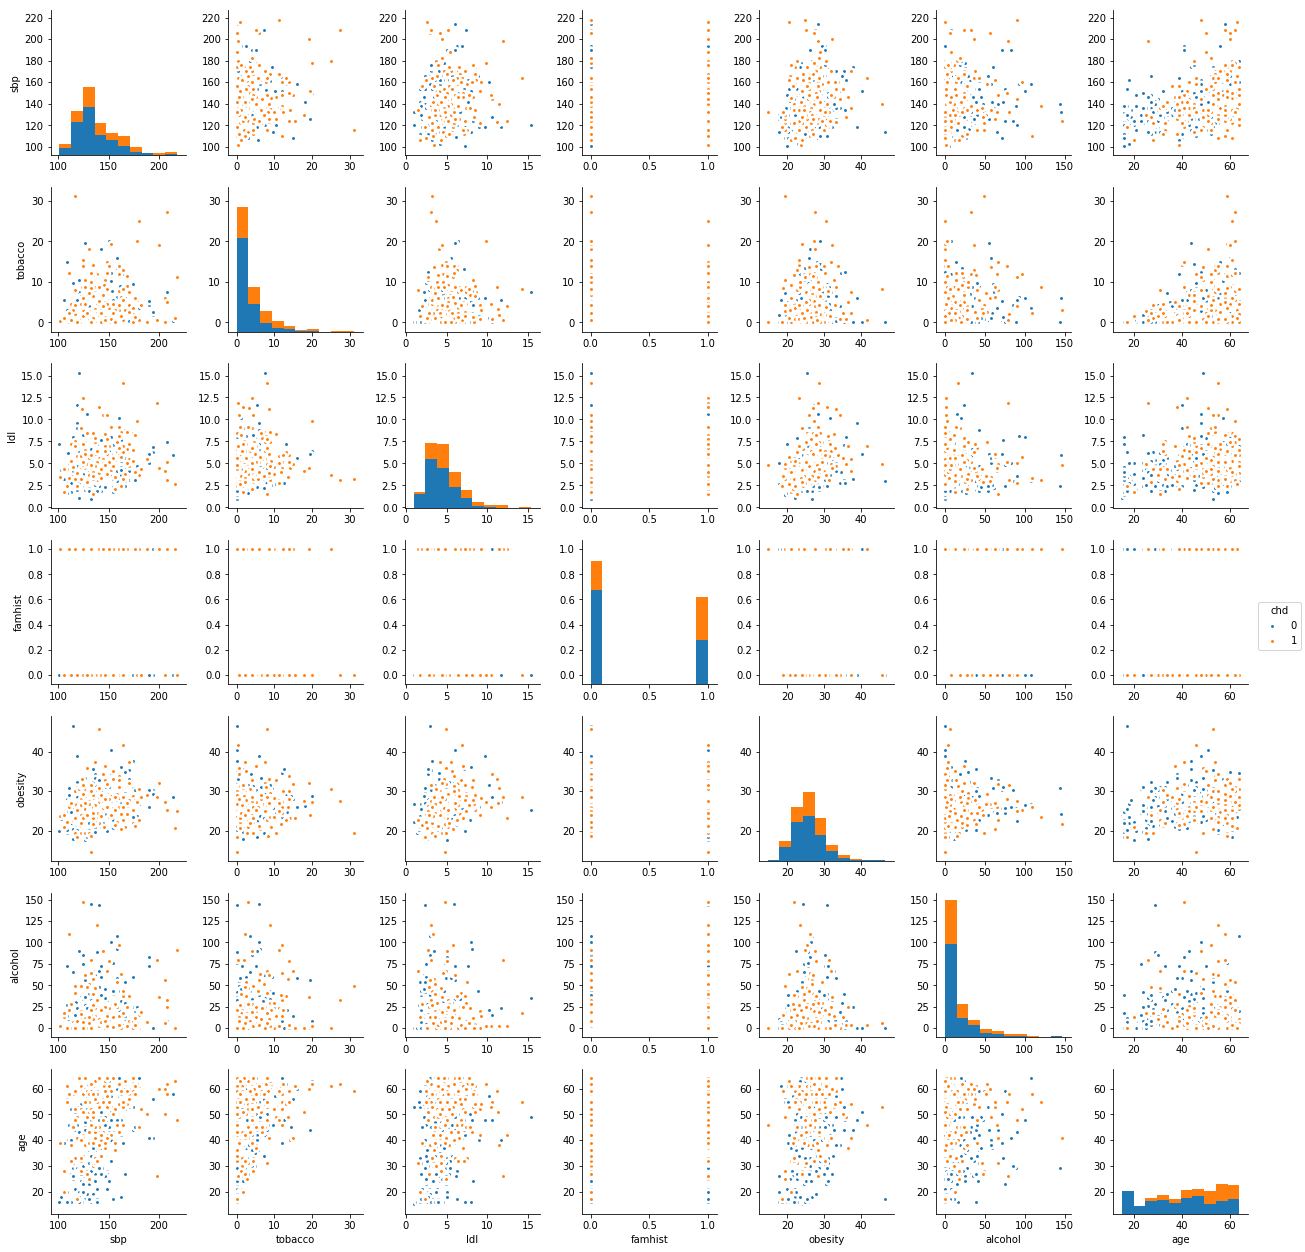

In [3]:
sns.pairplot(df, vars=names, kind="scatter", hue="chd", plot_kws=dict(s=30, edgecolor="white", linewidth=2.5))

In [4]:
X, y = df[names].values, df[['chd']].values

In [5]:
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)

In [8]:
ls = sm.Logit(y, sm.add_constant(X)).fit()
print(ls.summary(xname=['(Intercept)'] + names))

Optimization terminated successfully.
         Current function value: 0.522916
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                          Logit   Df Residuals:                      454
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:                  0.1895
Time:                        14:05:57   Log-Likelihood:                -241.59
converged:                       True   LL-Null:                       -298.05
                                        LLR p-value:                 2.259e-21
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
(Intercept)    -4.1296      0.964     -4.283      0.000      -6.019      -2.240
sbp             0.0058    

In [17]:
data = df[names]
remaining = set(data.columns)
selected = []
current_score, best_new_score = 0.0, 0.0
while remaining and current_score == best_new_score:
    scores_with_candidates = []
    for candidate in remaining:
        X = data[selected + [candidate]].values
        score = sm.Logit(y, sm.add_constant(X)).fit().prsquared
        scores_with_candidates.append((score, candidate))
    scores_with_candidates.sort()
    best_new_score, best_candidate = scores_with_candidates.pop()
    if current_score < best_new_score:
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score

Optimization terminated successfully.
         Current function value: 0.600268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548331
  

In [18]:
selected

['age', 'famhist', 'tobacco', 'ldl', 'obesity', 'sbp', 'alcohol']